<center>
    <img src="./assets/molssi_ai.png"
         alt="MolSSI-AI Logo"
         width=400 
         height=250
    />
</center>

## Learning Objectives
- Perform exploratory data analysis (EDA), data preprocessing and featurization
- Create and train a linear regression model and apply it to solve a practical cheminformatics problem
- Evaluate the performance of the trained models on test data
- Determine the importance of cross-validation on the quality of the trained models
- Use PyCaret to automate the process of creating, training and evaluating the regression models

Before we start, let's make sure we have the necessary libraries ready for use.  First, we will install two new packages that are not included in the default packages.  The `sweetviz` package will help us visualize data sets quickly.  The `pycaret` package will help us compare different machine learning models.  For the installation commands to work in the jupyter notebook, they each have to be in their own code cell by themselves.

In [ ]:
pip install sweetviz

In [ ]:
pip install pycaret

In [1]:
import pandas as pd                 # for data manipulation
import seaborn as sns               # for data visualization
import matplotlib.pyplot as plt     # for data visualization
import numpy as np                  # for numerical operations

from sklearn.preprocessing import StandardScaler            # for scaling the data
from sklearn.model_selection import train_test_split        # for splitting the data into training and testing sets
from sklearn.model_selection import cross_val_score, KFold  # for K-fold cross-validation
from sklearn.linear_model import LinearRegression           # for creating a linear regression model
from sklearn.dummy import DummyRegressor                    # for creating a base regressor to compare the model with
from sklearn.metrics import mean_squared_error, r2_score    # for evaluating the model
from sklearn.pipeline import make_pipeline                  # for building operational pipelines

import sweetviz as sv

<div class="alert alert-block alert-info">
    <b>Note</b>
    We have added comments to clarify the purpose of each imported library.
</div>

## Problem Statement

In this tutorial, we will be working on a **supervised learning** problem which involves both featurized data and their corresponding labels. The goal is to predict the solubility of a molecule base on its chemical structure using regression models. We are going to use the [Delaney's solubility dataset](https://doi.org/10.1021/ci034243x). It contains the chemical structures of 1144 compounds along with their experimentally measured solubility in mol/L. We provide a preprocessed version of the [dataset](https://github.com/MolSSI-Education/bcce-2024/tree/main/data) in the comma-separated value (CSV) format.

Let's load the solubility data using the ``pandas`` library 
and take a look at a few samples in the dataset

In [2]:
# Path to the preprocessed data file
data_path = "./data/solubility-processed.csv"

# Read the data into a DataFrame
df = pd.read_csv(data_path)

# Display the first few rows of the DataFrame
df.head()

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
0,2.5954,167.850,0.0,0.0,-2.18
1,2.3765,133.405,0.0,0.0,-2.00
2,2.5938,167.850,1.0,0.0,-1.74
3,2.0289,133.405,1.0,0.0,-1.48
4,2.9189,187.375,1.0,0.0,-3.04


The dataset contains the following columns:
- **MolLogP**: solubility values estimated by [Daylight CLOGP version 4.72](https://www.daylight.com/dayhtml/doc/clogp/index.html)
- **MolWt**: molecular weight
- **NumRotatableBonds**: number of rotatable bonds
- **AromaticProportion**: the portion of heavy atoms that are in an aromatic ring
- **logS**: the solubility of the molecule in mol/L measured at 25 $\degree C$ 

### Sidebar: A Brief Note on Solubility

The solubility of a molecule is a critical property in medicinal chemistry, drug discovery, and agrochemistry as it determines the bioavailability of a drug or pesticide.
**Partition coefficient**, $P$, measures the propensity of a neutral compound to dissolve in a mixture of two immiscible solvents, often water and octanol. In simple terms, it determines how much of a solute dissolves in the aqueous phase versus the organic portion.

The partition coefficient is defined as:

$$
P = \frac{[Solute]_{\text{organic}}}{[Solute]_{\text{aqueous}}}     
$$

where $[Solute]_{\text{organic}}$ and $[Solute]_{\text{aqueous}}$ are the concentrations of the solute in the organic and aqueous phases, respectively.
Instead of $P$, we often use the logarithm of the partition coefficient, $\log P$, which is more convenient to work with. A negative value of $\log P$ indicates that the solute is more soluble in water, while a positive value indicates that the solute is more soluble in the organic phase. When $\log P$ is close to zero, the solute is equally soluble in both phases. Although $\log P$ is a constant value, its magnitude is dependent on the measurement conditions and the choice of the organic solvent.

<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    What does logP value of 1 mean?
</div>

#### Solution

A $\log P$ value of 1 indicates that the solute is 10 times more soluble in the organic phase than in the aqueous phase.

## Exploratory Data Analysis (EDA)

The first step after stating the problem is to perform exploratory data analysis (EDA) on raw data. The EDA is crucial for data preprocessing pipelines as it helps us understand the nature of our data, identify the key patterns and relationships, and detect anomalies. The EDA involves summarizing the main characteristics of the data, often using visual methods. 

Loading the data into a Pandas DataFrame provides a convenient way to perform EDA. Let's start by getting a high-level overview of the dataset
using the ``info`` function

                                             |                | [  0%]   00:00 -> (? left)


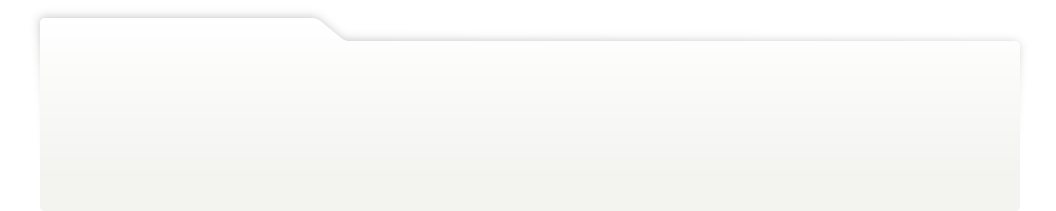
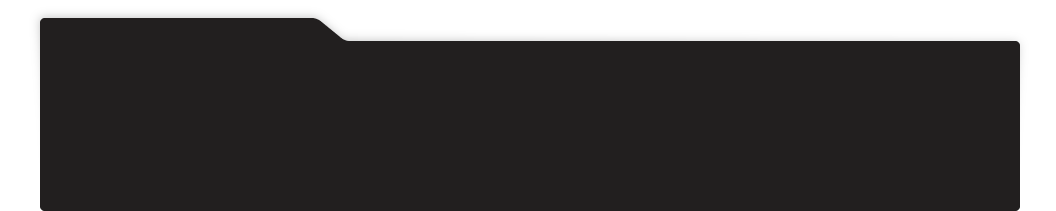
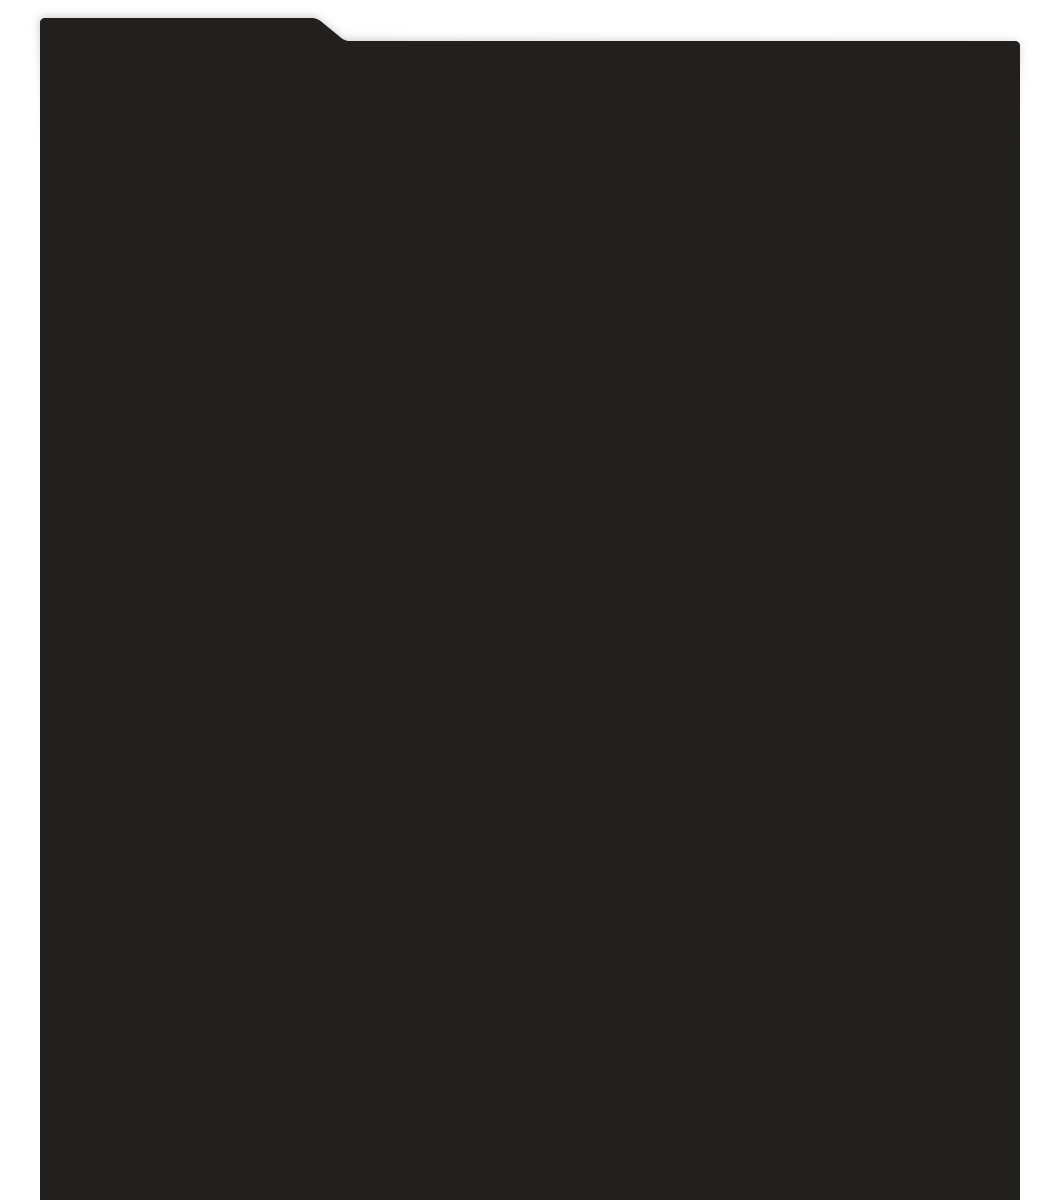
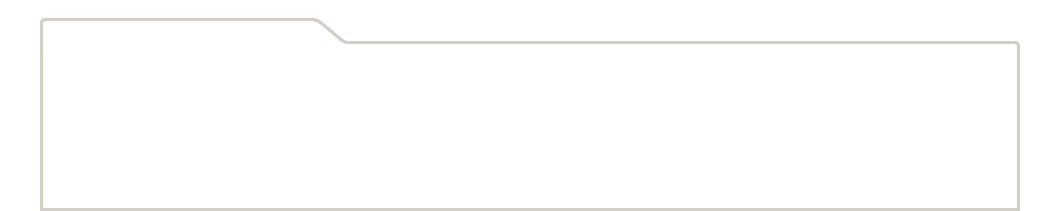
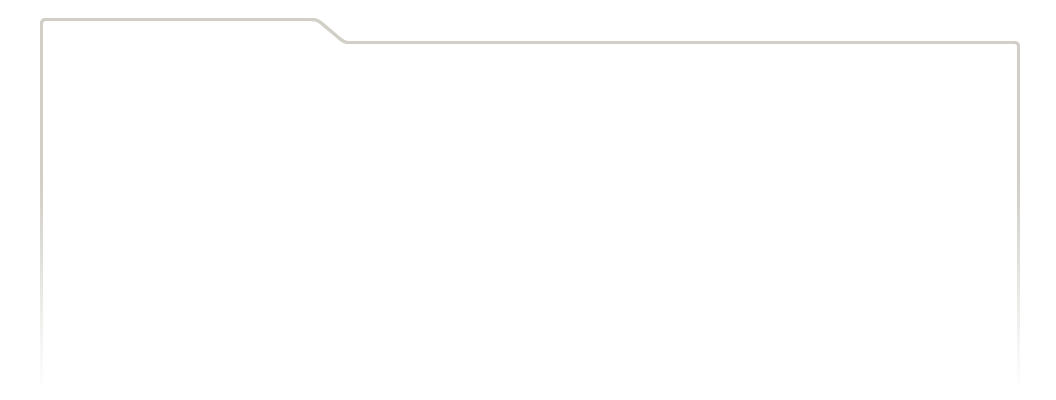
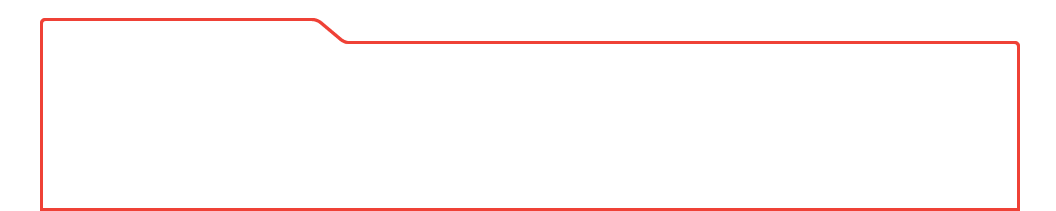
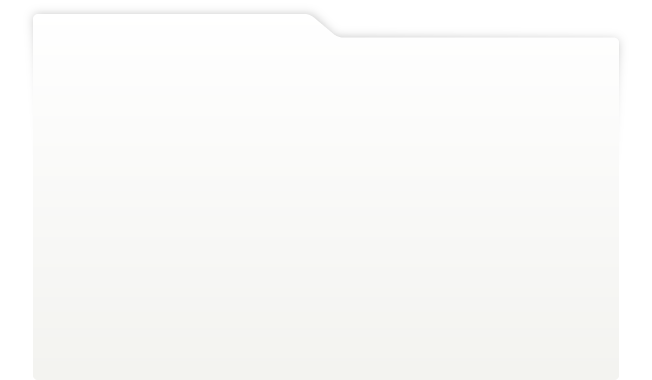
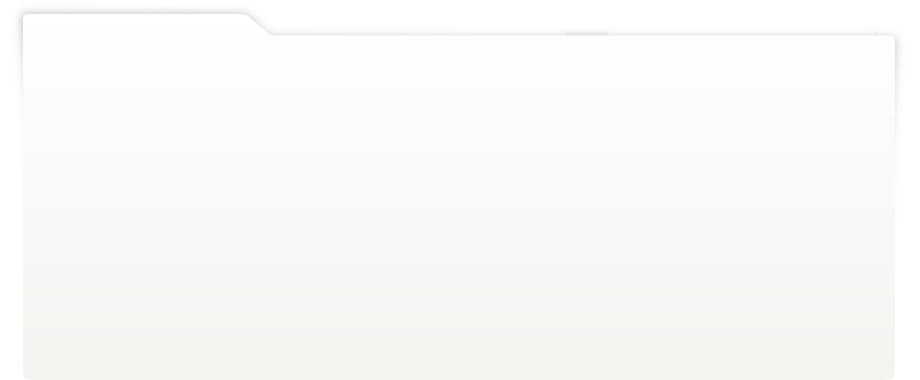
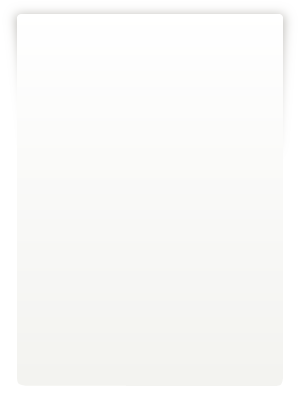
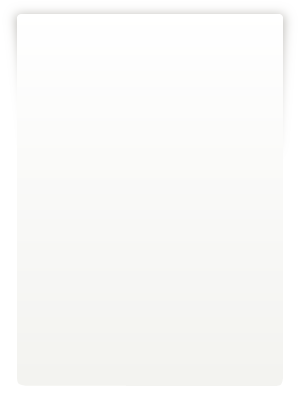
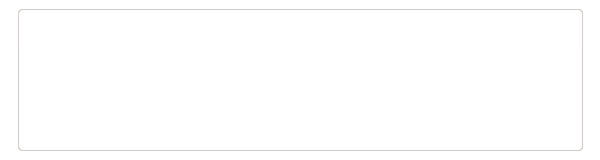
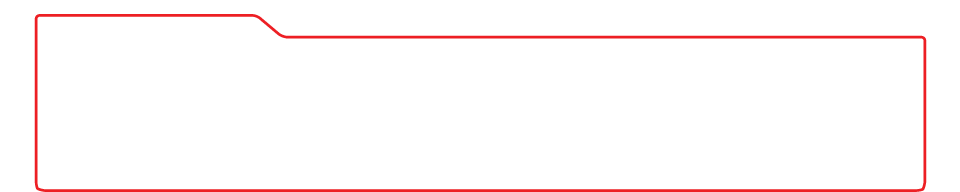
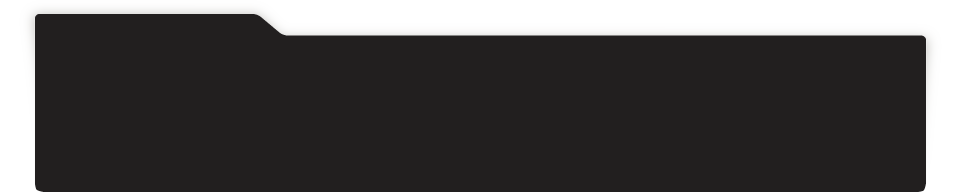
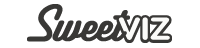
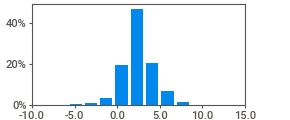
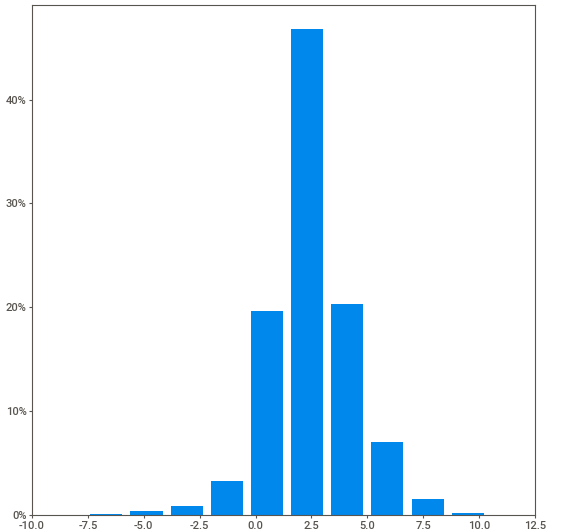
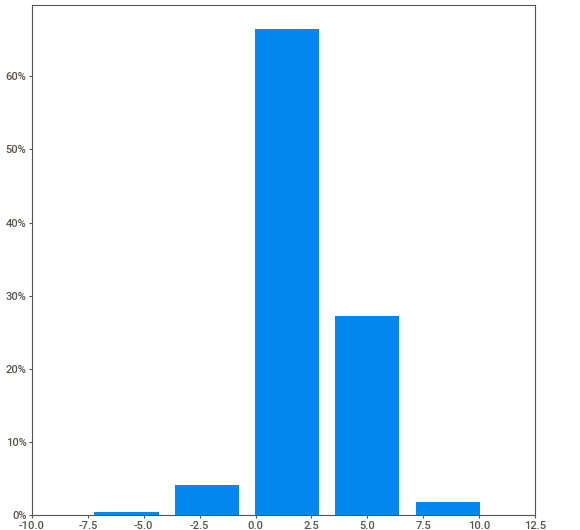
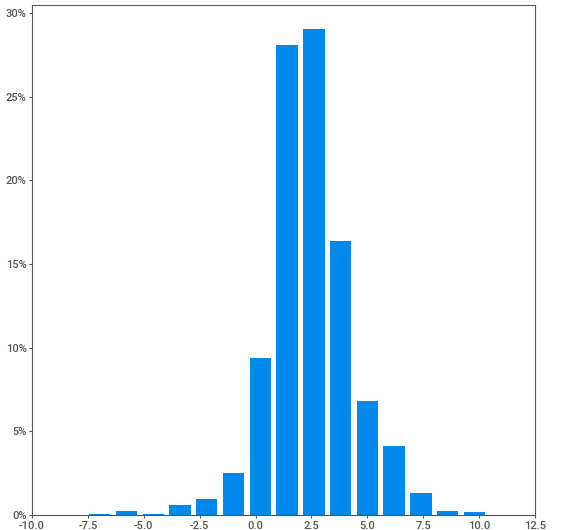
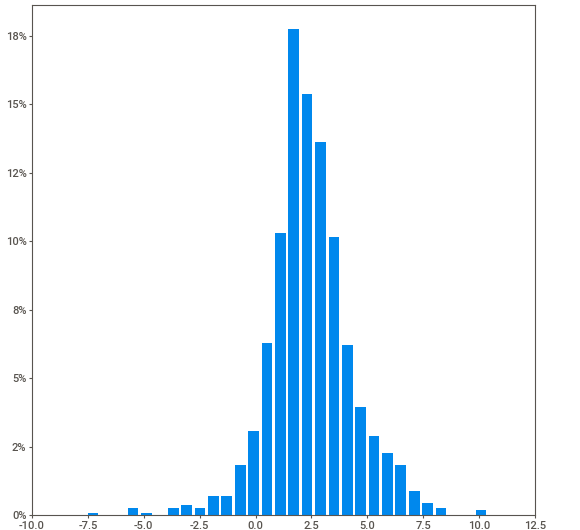
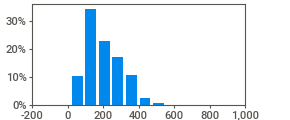
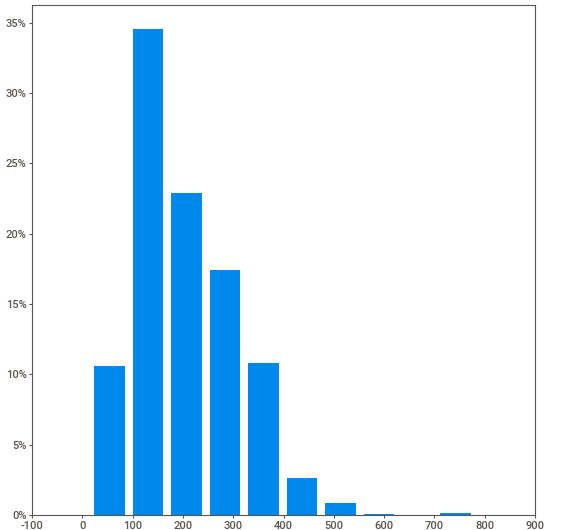
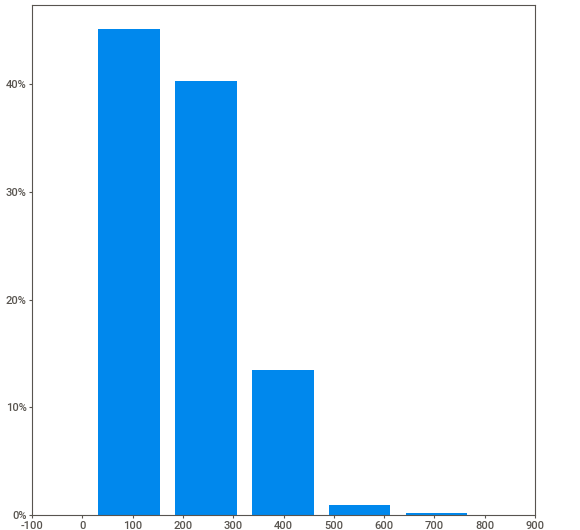
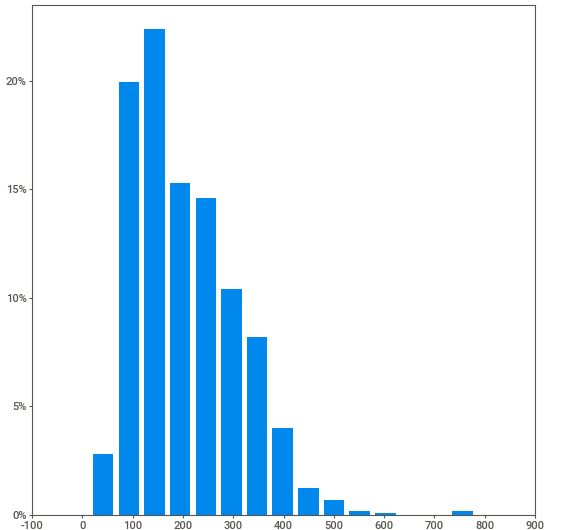
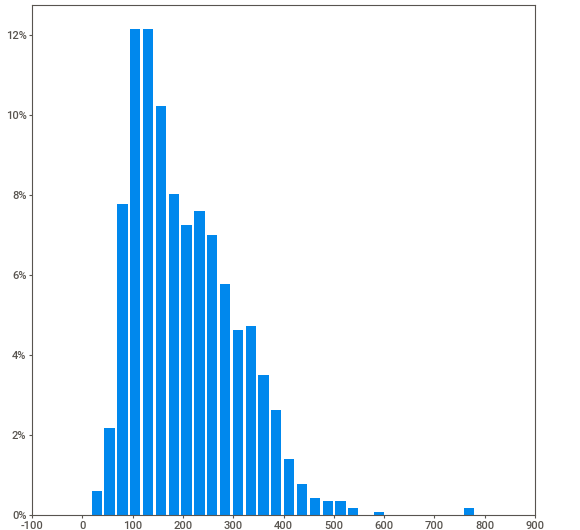
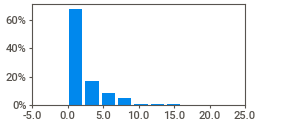
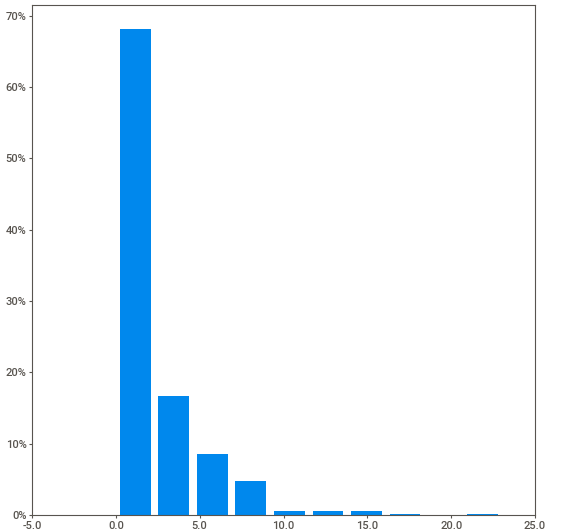
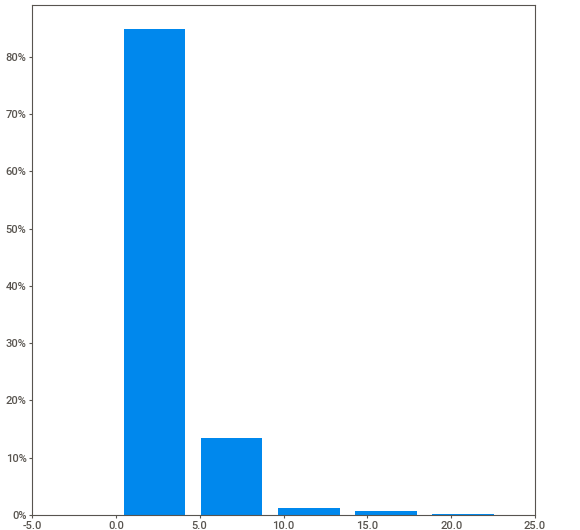
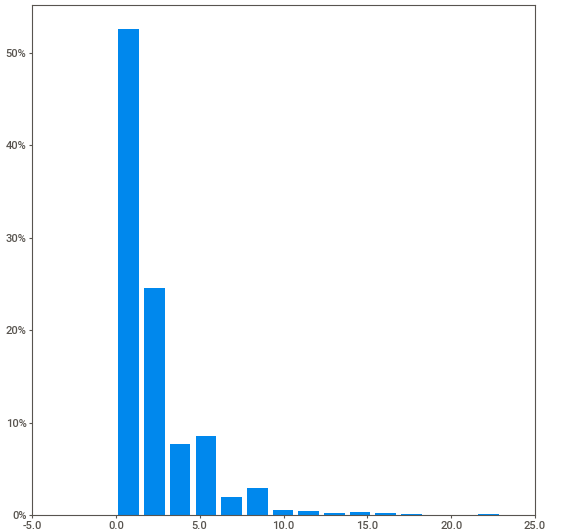
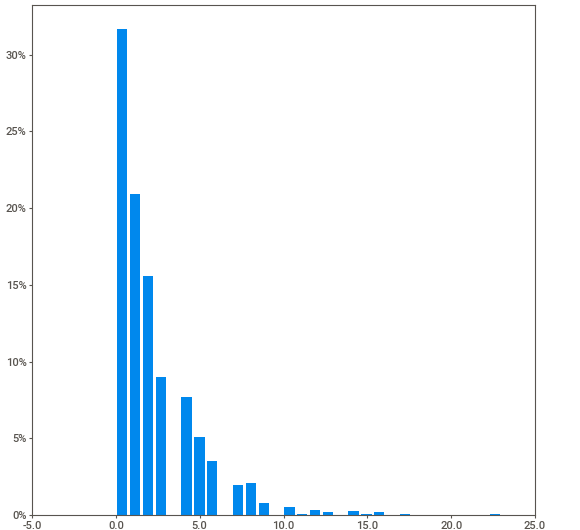
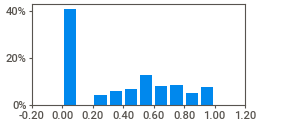
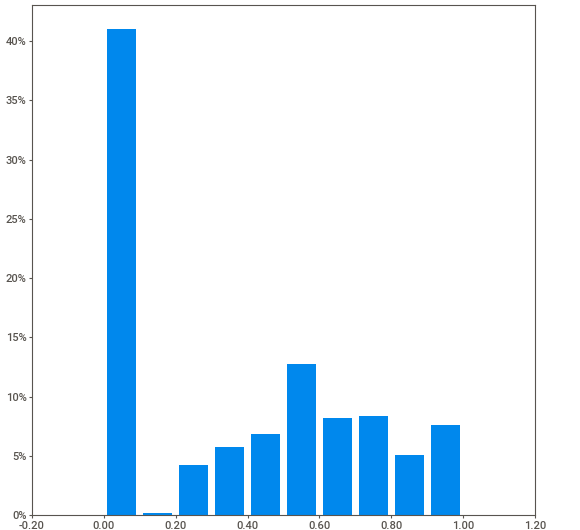
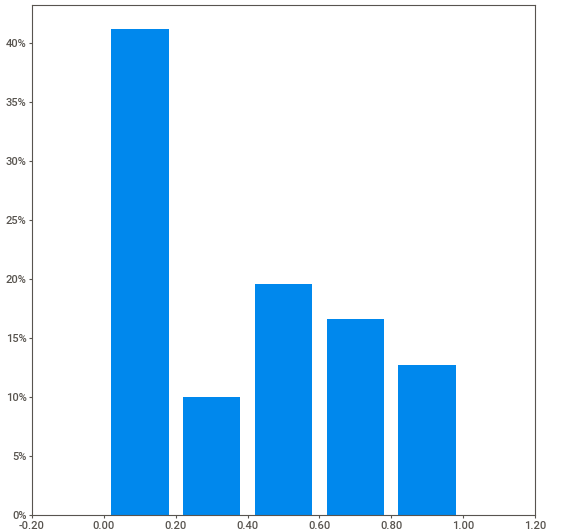
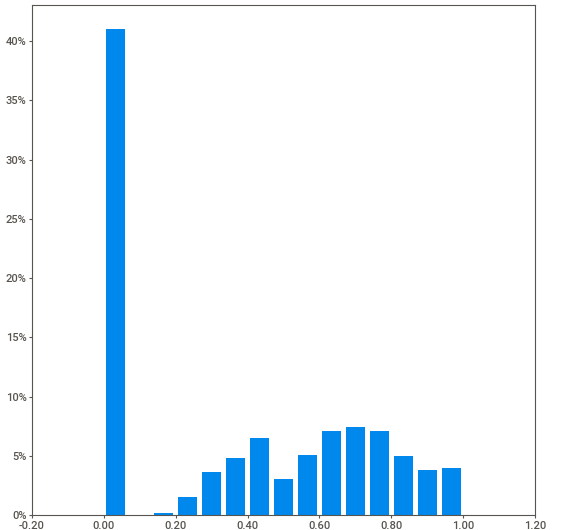
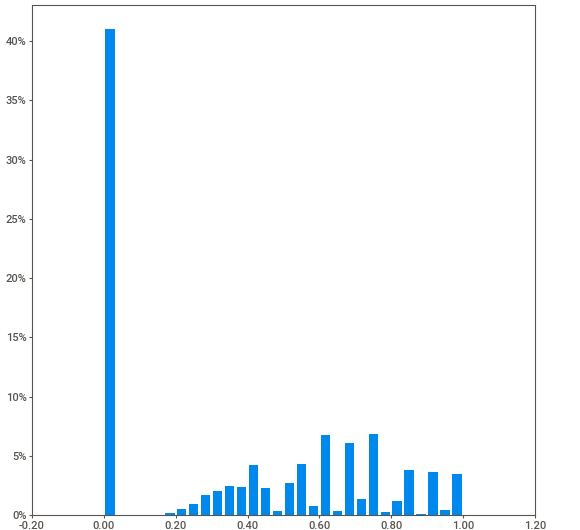
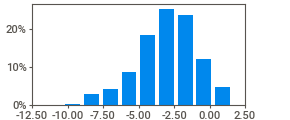
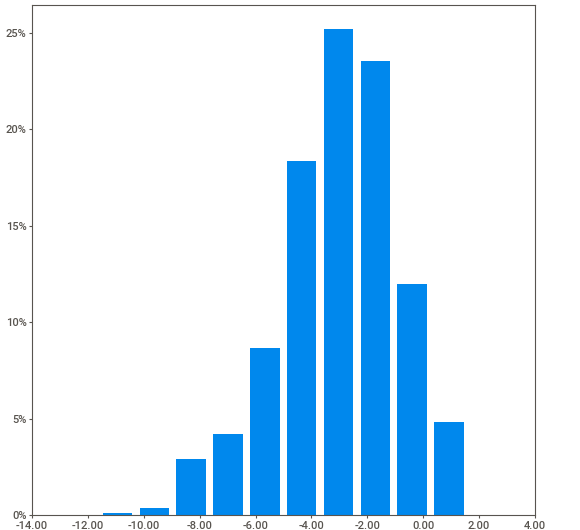
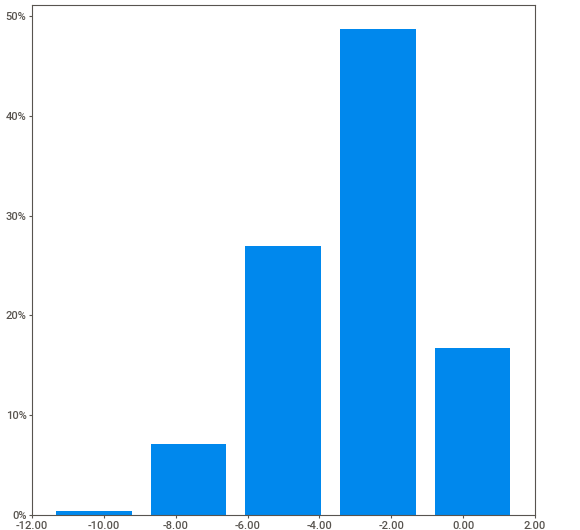
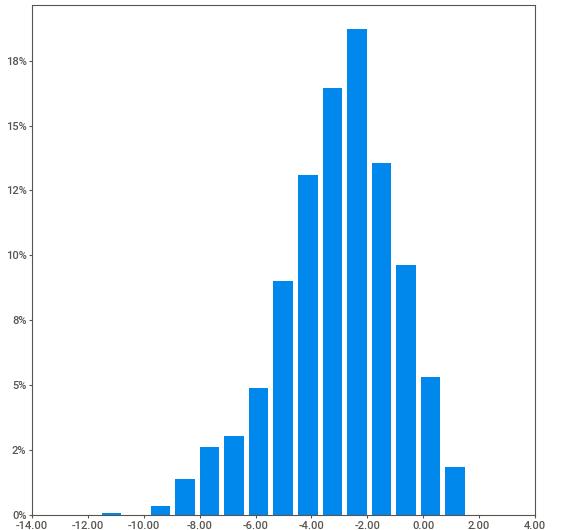
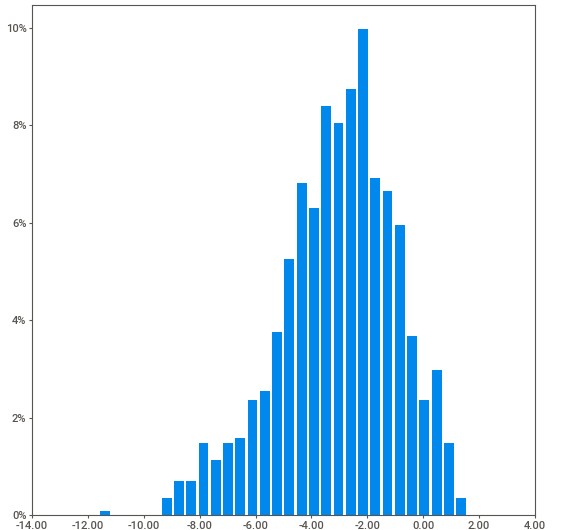
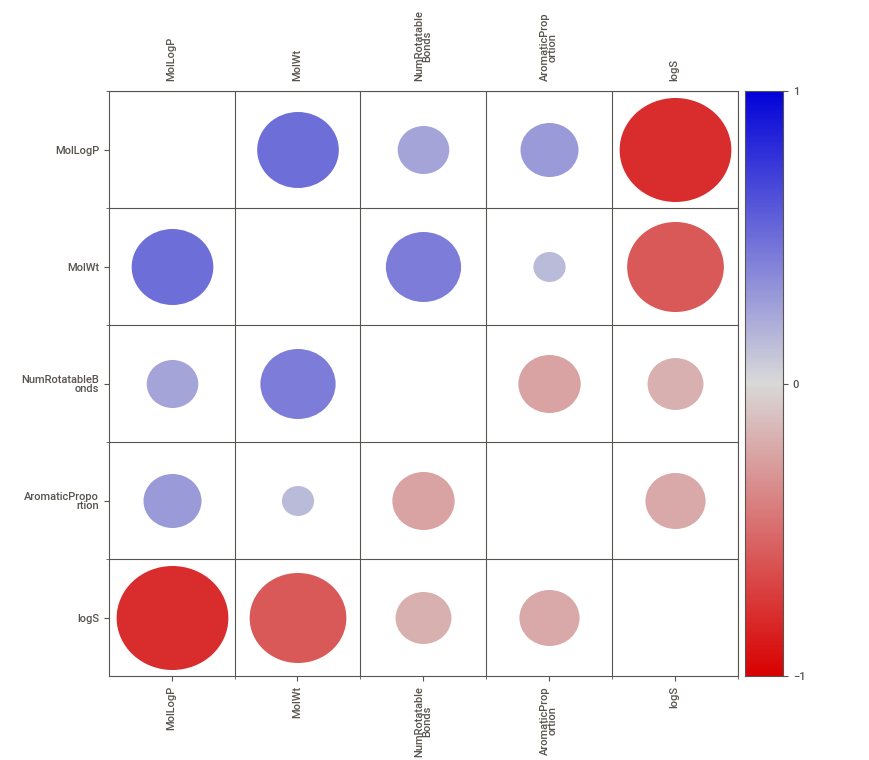
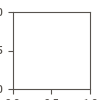

In [3]:
 # Analyse Dataset
report = sv.analyze(df)

    # View and Save
report.show_notebook()

### Checking for missing values
Since the data is already preprocessed, the number of ``Missing`` values for all features should be zero. The experimentally measured solubility in the last column ``logS`` is the target variable and the remaining columns are the features.

<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    Are there any missing values in the data set?
</div>

### Statistical summary of the data
We also see a statistical summary of each numerical features in our dataset. The provided statistics include the count (values_, mean, standard deviation, minimum, 25th percentile, median, average, 75th percentile, and maximum values for each feature.

This information is extremely useful for understanding the data and the distribution of the features. It helps in identifying anomalies in the data or if our data requires any preprocessing. 

<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    What is the range of the logS values in this dataset?
    </div>

### Skewedness
The skewedness of the data, which is determined by comparing the mean and median values, is also provided.

The numerical values of skewness can be interpreted using the following rules:
- The skewness value of zero indicates a perfect symmetrical distribution,
- a skewness between -0.5 and 0.5 indicates an approximately symmetric distribution,
- a skewness between -1 and -0.5 (or 0.5 and 1) indicates a moderately skewed distribution,
- a skewness between -1.5 and -1 (or 1 and 1.5) indicates a highly skewed distribution, and
- a skewness less than -1.5 (or greater than 1.5) indicates an extremely skewed distribution.

<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    Use the skewness rules and the histograms to categorize the skewness of all five properties based on the calculated skewness values.
</div>

### Correlation of features with target variable
The correlation matrix between the features and the target variable provides insights into the relationships between the features and the target variable(s). You may need to click on the "Associations" button in order to see the correlation matrix.

A correlation value close to 1 indicates a strong positive relationship, while a correlation value close to -1 indicates a strong negative relationship. A correlation value close to 0 indicates no relationship between the features.

The coloring scheme makes it easy to uncover the relationships between the features. The darker the color, the stronger the correlation. The diagonal line represents the correlation of each feature with itself, which is always 1. The blue color indicates a positive correlation, while the red color signifies a negative correlation (based on the provided key).

<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    Based on the correlation plot, which feature is most strongly correlated with the logS value? And is it a negative or positive correlation?
</div>

## Splitting the data into training and testing sets

Once we have a good understanding of the data, we can move on to the next step, which is splitting the data into a training set and a testing set. The training set is used to train the model, and the testing set is used to evaluate the model's performance. This process allows you to test the model's accuracy on unseen data and ensures that the model can generalize well to new data.

It is extremely important to split the data first and then perform subsequent feature engineering steps. Feature engineering prior to splitting the data can cause a <b>data leakage</b> problem, allowing the model to "see" the testing data in the training phase. This violates our intention to treat the test data as a good representative sample of the real-world data. Data leakage leads to a model that performs well in training and testing but that performs poorly when given novel data.

To create our training and testing data sets, we will use the ``train_test_split`` function from the ``sklearn.model_selection`` module to split the data. The training set will be used to train the model, while the testing set will be used to evaluate the model's performance.

The next step in the feature engineering process is to split the data into features and target variables. We will use the ``train_test_split`` function from the ``sklearn.model_selection`` module to split the data into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate the model's performance.

Useful information about the train test split process:
- ``x`` is generally used as the label for the input variables (the data the model will use to make predictions)
- ``y`` is generally used as the label the target variable (what we are trying to predict)
- ``test_size`` is used to assign the percentage of the data set aside for the testing set
- ``random_state`` controls the random number generator used to shuffle the data before splitting it. In other words, it ensures that the same randomization is used each time you run the code, resulting in the same splits of the data. This is especially useful if you want to compare the performance of multiple models
- ``shuffle = True`` ensures that the data is split randomly, to prevent any randomizing and pre-existing sorting in the original data, ensuring we do not generate train and test sets that are markedly different in content from one another

In [4]:
# Create the feature matrix (X), feature vector (x), and the target vector (y)
X = df.drop(columns=['logS'])
x = X["MolLogP"]
y = df['logS']

# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=True)

# Reshape the data into 2D arrays of shape (n_samples, 1)--need if only one input feature
x_train = x_train.values.reshape(-1,1)
x_test = x_test.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

# Display the shapes of the training and testing sets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((915, 1), (229, 1), (915, 1), (229, 1))

<div class="alert alert-block alert-info">
    <b>Note</b>
    Note the use of the <b>x</b> vector in the <b>train_test_split</b> function as initially we will train a model using only one input feature.<br> If we instead want to use all the available features we would need to use the <b>X</b> matrix that we have defined.
</div>

## Feature Engineering

Once we have a good understanding of the data, we can move on to the next step, which is feature engineering. Feature engineering is the process of transforming the raw data into a format that is suitable for machine learning models. Feature engineering often involves creating new features, selecting the most important features, and transforming the existing features in order to improve the model's performance.

After splitting our data, we need to scale our train and test features. Scaling is a crucial step in the data preprocessing pipeline as it ensures that all features have the same scale, since many machine learning models are sensitive to the scale of the input features. We will use the ``StandardScaler`` from the ``sklearn.preprocessing`` module to scale our features. ``StandardScaler`` transforms the data in such a manner that it has mean value of 0 and a standard deviation value of 1.

In [5]:
# Create the standard scaler object
scaler = StandardScaler()

# Fit and transform the training feature vector x_train
x_train_scaled = scaler.fit_transform(x_train)

# Transform the test feature vector x_test
x_test_scaled = scaler.transform(x_test)

# Make sure the training data is scaled correctly
print(f" Training feature mean: {x_train_scaled.mean():.5f}")
print(f" Training feature standard deviation: {x_train_scaled.std():.5f}\n")

# Print the scaler statistics on the test data
print(f" Testing feature mean: {x_test_scaled.mean():.5f}")
print(f" Testing feature standard deviation: {x_test_scaled.std():.5f}")

 Training feature mean: -0.00000
 Training feature standard deviation: 1.00000

 Testing feature mean: -0.02540
 Testing feature standard deviation: 1.07506


<div class="alert alert-block alert-info">
    <b>Reminder:</b>
    It is extremely important to split the data first and then fit the scaler on the training data, only. Fitting the scaler on the entire data and then splitting it causes the <b>data leakage</b> problem which violates our intention to treat the test data as a good representative sample of the real-world data.  
</div>


## Building and Training a Linear Regression Model

### Dummy Model

The next step after the data preparation is to build and train our model. We will build a simple linear regression model which focuses on the relationship between a single feature (``MolLogP``) and the target variable (``logS``). 

<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    What is the reason behind choosing <b>MolLogP</b> as our main feature in the linear regression model?
</div>

In order to evaluate the performance of our model, we can first create a dummy "model" using the ``DummyRegressor`` class from the ``sklearn.dummy`` module. This class provides a simple way to create a model that calculates the mean value of the target feature and predicts this mean value for each observation. The ``fit`` method is used to train the model on the training data. Once the model is trained, we can use the ``predict`` method to make predictions on the test data. Note that the ``DummyRegressor`` is not for solving real problems!

In [6]:
# Create a dummy model using the mean value of the target property
dummy_model = DummyRegressor(strategy="mean")

# Fit the model to the training data
dummy_model.fit(x_train_scaled, y_train)

# Make predictions on the testing data
y_pred_dummy = dummy_model.predict(x_test_scaled)

# Calculate the performance metrics and store them in a DataFrame
results = pd.DataFrame({
    "Coefficients": [np.array(dummy_model.constant_)],   # the regression coefficient
    "MSE": mean_squared_error(y_test, y_pred_dummy),     # the mean squared error
    "R2": r2_score(y_test, y_pred_dummy)                 # the coefficient of determination
}, index=["Dummy"])
                            

# Set the formatting style
results.style.format(
    {
        "MSE": "{:.3f}",
        "R2": "{:.2f}"
    }
)

,Coefficients,MSE,R2
Dummy,[[-3.07538251]],4.586,-0.00


<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    Do we want to maximize or minimize the MSE value? What about R2?
</div>

### Linear Regression Model

Let's next build and train a single-feature input linear regression model. We will use the ``LinearRegression`` class from the ``sklearn.linear_model`` module to create the model. 

In [7]:
# Create a simple linear regression model
simple_reg_model = LinearRegression()

# Fit the model to the training data
simple_reg_model.fit(x_train_scaled, y_train)

# Make predictions on the test data
y_pred_simple = simple_reg_model.predict(x_test_scaled)

# Calculate the performance metrics
simple_model_results = pd.DataFrame({
    "Coefficients": [np.array(simple_reg_model.coef_)],   # the regression coefficient
    "MSE": mean_squared_error(y_test, y_pred_simple),     # the mean squared error
    "R2": r2_score(y_test, y_pred_simple)                 # the coefficient of determination
}, index=["Simple-Linear-Regression"])

# Store the results into results DataFrame
results = pd.concat([results, simple_model_results])
results

,Coefficients,MSE,R2
Dummy,[[-3.0753825136612023]],4.586189,-0.001647
Simple-Linear-Regression,[[-1.731915805006306]],1.533885,0.664992


<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    Which model is best at predicting the value of logS?
</div>

### Visualizing model performance

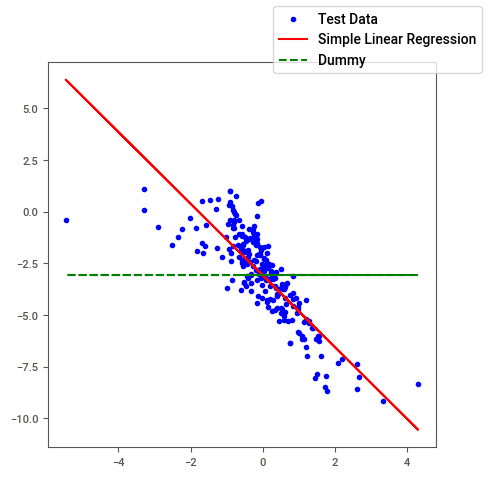

In [8]:
# Create a plot object 
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the test data
ax.scatter(x_test_scaled, y_test, color='blue', label='Test Data')

# Plot the simple linear regression model
ax.plot(x_test_scaled, y_pred_simple, color='red', label='Simple Linear Regression')

# Plot the baseline model
ax.plot(x_test_scaled, y_pred_dummy, "g--", label="Dummy")

# Create the legends
fig.legend(facecolor='white')

# Show the plot
plt.show()

### Multiple Linear Regression Model

Using the ``MolLogP`` feature with highest correlation with the target variable ``logS`` is a good starting point. The reason is that we knew beforehand that the CLOGP model would be a great predictor of solubility. However, we can improve our model by including other features that show some correlation with the target variable. This is where multiple linear regression comes in.

Let's build a multiple linear regression model using all the features in our dataset. The process is very similar to building a single-feature linear regression model: Once again, we need to scale the data, train the model on the scaled training data using the ``fit`` method, and make predictions on the test data using the ``predict`` function.

<div class="alert alert-block alert-info">
    <b>Note</b>
    Note the usage of <b>X</b> matrix instead of <b>x</b> vector in the <b>train_test_split</b> function, since now we want to use multiple features to predict the target variable.
</div>

In [9]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)

# Create the standard scaler object
scaler = StandardScaler()

# Fit and transform the training feature matrix X_train
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test feature matrix X_test
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
multi_feature_model = LinearRegression()

# Fit the model to the training data
multi_feature_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred_multi_feature = multi_feature_model.predict(X_test_scaled)

# Calculate the performance metrics
multi_feature_model_results = pd.DataFrame({
    "Coefficients": [np.array(multi_feature_model.coef_)],       # the regression coefficients
    "MSE": mean_squared_error(y_test, y_pred_multi_feature),     # the mean squared error
    "R2": r2_score(y_test, y_pred_multi_feature)                 # the coefficient of determination
}, index=["Multi-Linear-Regression"])

# Store the results into results DataFrame
results = pd.concat([results, multi_feature_model_results])
results

,Coefficients,MSE,R2
Dummy,[[-3.0753825136612023]],4.586189,-0.001647
Simple-Linear-Regression,[[-1.731915805006306]],1.533885,0.664992
Multi-Linear-Regression,"[-1.35808652024225, -0.668994315281511, -0.016...",1.127759,0.753692


<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    Which model is best at predicting the value of logS?
</div>

## Better Model Evaluation with Cross-Validation

We evaluate the performance of our trained model on the test dataset. However, the measured performance depends on the quality of the data in the splits (train/validation/test).
In order to ameliorate this issue, we can use a technique called $k$-fold cross-validation. The $k$-Fold cross-validation method splits the data into $k$ subsets,
trains the data on the union of $k-1$ sets and measures the performance of the trained model on the $k$-th set, and repeats the process $k$ times to cover all subsets.
The performance score is reported as the average score of $k$ experiments.

<div style="text-align:center;">
  <img src="Images/K-fold_cross_validation_EN.svg" style="display: block; margin: 0 auto; max-height:400px;">
</div>
<br>
<br>

Here, we use the ``cross_val_score`` function from the ``sklearn.model_selection`` module to perform a 5-fold cross validation experiment.

In [10]:
# Create a standard scaler object
scaler = StandardScaler()

# Create a linear regression model
multi_feature_model = LinearRegression()

# Create a pipeline object
pipeline = make_pipeline(scaler, multi_feature_model)

# Create a KFold object with 5 folds (defined using n_splits)
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Perform cross-validation
cv_results = cross_val_score(pipeline, X, y, cv=kf, scoring="neg_mean_squared_error")

# Calculate the mean and standard deviation of the cross-validation results
print(f"CV Results Mean MSE: {-cv_results.mean():.5f}")
print(f"CV Results STD MSE: {cv_results.std():.5f}")

CV Results Mean MSE: 1.01729
CV Results STD MSE: 0.07631


<div class="alert alert-block alert-success"> 
    <b>Bonus Exercise (if you have time)</b>
    Copy and paste the above code into the cell below to perform a 5-fold cross-validation using a simple linear regression model and compare the results with the previous model evaluation
    based on the R^2 metric.
</div>

In [ ]:
## perform a 5-fold cross-validation for a simple linear regression model



### Solution to bonus exercise

```python

    from sklearn.model_selection import cross_val_score, KFold
    from sklearn.pipeline import make_pipeline

    # Create a standard scaler object
    scaler = StandardScaler()

    # Create a linear regression model
    simple_linear_model = LinearRegression()

    # Create a pipeline object
    pipeline = make_pipeline(scaler, simple_linear_model)

    # Create a KFold object
    kf = KFold(n_splits=5, shuffle=True, random_state=123)

    # Perform cross-validation   Note we use x instead of X as the input data
    cv_results = cross_val_score(pipeline, x, y, cv=kf, scoring="r2")

    # Calculate the mean and standard deviation of the cross-validation results
    print(f"CV Results Mean MSE: {cv_results.mean():.5f}")
    print(f"CV Results STD MSE: {cv_results.std():.5f}")

```

## Is linear regression really the best model for this task? 

You have learned about the basics of linear regression,
exploratory data analysis, feature engineering, and model evaluation. However, the process of building
and evaluating multiple machine learning models to find the one best suited for your purposes can be time-consuming and repetitive.

**PyCaret** is an open-source, low-code machine learning library written in Python that automates building 
the end-to-end machine learning processes. It provides a simple and efficient way to build, evaluate, and 
compare machine learning models. PyCaret is designed to help data scientists and machine learning engineers
focus on the data and the problem at hand rather than the code.

Let's see how we can use PyCaret to build and evaluate a wide range of machine learning models with just a
few lines of code. First, we need to import the regression modules from PyCaret

In [11]:
from pycaret.regression import *

After importing PyCaret's regression modules, we can create a PyCaret experiment using the ``setup`` function.
The ``setup`` function automatically preprocesses the data, splits it into training and testing sets, 
and sets up the environment for building and evaluating machine learning models.

In [12]:
s = setup(data = df, target = 'logS', session_id = 123, fold = 5, n_jobs = 1)

FloatingPointError: underflow encountered in cast

Now, we can compare the performance of different machine learning models using the
``compare_models`` function. The function trains and evaluates a wide range of 
machine learning models on the input data and displays a table of the models' 
performance metrics.

In [ ]:
best = compare_models()

### Which model is best?

- PyCaret shows which model it has determined is "best"
- There are many metrics for scoring model performance. One good source for exploring other metrics is the ``sklearn.metrics`` section of the scikit-learn documentation (https://scikit-learn.org/stable/modules/model_evaluation.html)
- Required computing time is also an important metric
- Explainability is also important, especially if you are working with stakeholders who are not experts in machine learning
- You need to decide which model is the best for your purposes

###  Identifying the most important features

Feature importance measures how much each feature contributes to a specific build of a model, and many models allow you to display the feature importances after training a model. PyCaret can show the feature importance for the best model.

Let's take a look at the feature importance plot for the best performing model:

In [ ]:
plot_model(best, plot='feature')

Which features are most important in your plot?

- Can change between different training instances (especially if random state not set)
- Is often different for different types of model

Other options for the ``plot_model`` function to explore on your own:
    
* ``pipeline`` - Schematic drawing of the preprocessing pipeline
* ``residuals_interactive`` - Interactive Residual plots
* ``residuals`` - Residuals Plot
* ``error`` - Prediction Error Plot
* ``cooks`` - Cooks Distance Plot
* ``rfe`` - Recursive Feat. Selection
* ``learning`` - Learning Curve
* ``vc`` - Validation Curve
* ``manifold`` - Manifold Learning
* ``feature`` - Feature Importance
* ``feature_all`` - Feature Importance (All)
* ``parameter`` - Model Hyperparameter
* ``tree`` - Decision Tree

## Bonus Section: EDA using python code

We used the SweetViz library to do all our exploratory data analysis (EDA) in just a few lines of code. Sometimes, however, it is desirable to do additional exploration on your own. Below is the python code necessary to do the same analysis that SweetViz performed. This code provides a good set of templates for doing your own customized EDA.

We can get a high-level overview of the dataset using the ``info`` function

In [ ]:
df.info()

Since the data is already preprocessed, the value of ``Non-Null Count`` columns for all features should be equal to the total number of samples in the dataset, *i.e.,* 1144. All features are of numerical type ``float64``. The experimentally measured solubility in the last column ``logS`` is the target variable and the remaining columns are the features.

In addition to ``info()``, Pandas provides another useful function called ``describe`` which provides a statistical summary of all numerical features in our dataset. The provided statistics involve the count, mean, standard deviation, minimum, 25th percentile, median, 75th percentile, and maximum values for each feature.

In [ ]:
df.describe()

This information is extremely useful for understanding the data and the distribution of the features. It helps in identifying any missing values or anomalies in the data or if our data requires any preprocessing. 

Visualizing the data can also be helpful. For example, the skeweness of the data, which is determined by comparing the mean and median values, can be visualized using Pandas's ``hist`` function

In [ ]:
df.hist(figsize=(8,8), edgecolor='black', grid=False)

Clearly, the ``MolLogP`` solubility values are normally distributed while other features are more or less positively or negatively skewed. The Pandas library helps us quantify these observations for each feature using the ``skew`` function.

In [ ]:
df.skew()

The numerical values of skewness can be interpreted using the following rules:
- The skewness value of zero indicates a perfect symmetrical distribution,
- a skewness between -0.5 and 0.5 indicates an approximately symmetric distribution,
- a skewness between -1 and -0.5 (or 0.5 and 1) indicates a moderately skewed distribution,
- a skewness between -1.5 and -1 (or 1 and 1.5) indicates a highly skewed distribution, and
- a skewness less than -1.5 (or greater than 1.5) indicates an extremely skewed distribution.

Next, we use Pandas's ``corr`` function to calculate the correlation matrix between the features and the target variable. The correlation matrix provides insights into the relationships between the features and the target variable(s). A correlation value close to 1 indicates a strong positive relationship, while a correlation value close to -1 indicates a strong negative relationship. A correlation value close to 0 indicates no relationship between the features.

In [ ]:
df.corr(method='pearson')

An easy way to examine the relationships between the features and the target variable is to use a heatmap correlation matrix plot. 
We use the Seaborn library to create a heatmap plot of the correlation matrix as shown below

In [ ]:
# Create a plot object
plt.figure(figsize=(8,6))

# Calculate the correlation matrix
corr = df.corr()

# Create a heatmap
sns.set(font_scale=1.1)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")

# Display the heatmap
plt.show()

Our coloring scheme makes it easy to uncover the relationships between the features. The darker the color, the stronger the correlation. The diagonal line represents the correlation of each feature with itself, which is always 1. In this plot, the red color indicates a positive correlation, while the blue color signifies a negative correlation.